- French -> English hook
- English -> German hook
- High loss German bigrams when German neurons are ablated
- KDE summary statistics
- Effects of French neuron ablations/activations on loss of French and English datasets

## Setup

In [45]:
import haystack_utils
import math
import torch
import numpy as np
import seaborn as sns
from transformer_lens import HookedTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Plotly needs a different renderer for VSCode/Notebooks vs Colab
import plotly.io as pio
pio.renderers.default = "colab"  # "notebook_connected"
device = "cuda" if torch.cuda.is_available() else "cpu"

## Model and data loading

In [46]:
torch.autograd.set_grad_enabled(False)
torch.set_grad_enabled(False)
model = HookedTransformer.from_pretrained("pythia-70m-v0", fold_ln=True, device=device)

Using pad_token, but it is not set yet.


Loaded pretrained model pythia-70m-v0 into HookedTransformer


In [47]:
french = haystack_utils.load_txt_data("kde4_french.txt")
non_french = haystack_utils.load_txt_data("kde4_english.txt")

kde4_french.txt: Loaded 1007 examples with 505 to 5345 characters each.
kde4_english.txt: Loaded 1007 examples with 501 to 5295 characters each.


## Sparse probing to rediscover the french neuron

In [48]:
french_acts = haystack_utils.get_mlp_activations(french, 3, model, -1, context_crop_start=20, context_crop_end=21, mean=False)
non_french_acts = haystack_utils.get_mlp_activations(non_french, 3, model, -1, context_crop_start=20, context_crop_end=21, mean=False)

# Balanced dataset of activations on french and non-french data
smaller_size = min(len(french_acts), len(non_french_acts))
A = torch.concat((french_acts[:smaller_size], non_french_acts[:smaller_size]), dim=0).cpu().numpy()
y = np.array([1]*smaller_size + [0]*smaller_size)

print(A.shape, y.shape)

  0%|          | 0/1007 [00:00<?, ?it/s]

  0%|          | 0/1007 [00:00<?, ?it/s]

(2014, 2048) (2014,)


In [49]:
def get_important_neurons(A_train: np.ndarray, y_train: np.ndarray, k: int):
    # score each activation dimension by the difference between the means of
    # the classes 0 and 1
    A_train, y_train = torch.Tensor(A_train), torch.Tensor(y_train)
    class_0_mean = A_train[y_train == 0].mean(dim=0)
    class_1_mean = A_train[y_train == 1].mean(dim=0)
    scores = (class_1_mean - class_0_mean).abs()
    top_k_scores, top_k_indices = torch.topk(scores, k)
    return top_k_indices, top_k_scores

In [50]:
# Get top classification neurons in A using class labels y
k = 10
test_accs = []
train_accs = []
for i in range(1):
    A_train, A_test, y_train, y_test = train_test_split(A, y, test_size=0.1)
    top_k_indices, top_k_scores = get_important_neurons(A_train, y_train, k)
    lr_model = LogisticRegression()
    topk = top_k_indices.cpu().numpy().tolist()
    print(topk)
    A_train = A_train[:, [730, 1856, 1600]]
    A_test = A_test[:, [730, 1856, 1600]]
    lr_model.fit(A_train, y_train)
    test_acc = lr_model.score(A_test, y_test)
    train_acc = lr_model.score(A_train, y_train)
    test_accs.append(test_acc)
    train_accs.append(train_acc)

print(topk)
print(np.mean(train_accs))

[609, 705, 1361, 588, 902, 102, 37, 1715, 1847, 1932]
[609, 705, 1361, 588, 902, 102, 37, 1715, 1847, 1932]
0.6087196467991169


In [51]:
def get_top_individual_neuron_accuracy(k=10, n=5):
  test_accs = np.zeros((n, k))
  train_accs = np.zeros((n, k))
  for i in range(n):
      A_train, A_test, y_train, y_test = train_test_split(A, y, test_size=0.1)
      top_k_indices, top_k_scores = get_important_neurons(A_train, y_train, k)
      lr_model = LogisticRegression()
      topk = top_k_indices.cpu().numpy().tolist()
      for k_index, neuron in enumerate(topk):
          A_train_tmp = A_train[:, [neuron]]
          A_test_tmp = A_test[:, [neuron]]
          lr_model.fit(A_train_tmp, y_train)
          test_acc = lr_model.score(A_test_tmp, y_test)
          train_acc = lr_model.score(A_train_tmp, y_train)
          test_accs[i, k_index] = test_acc
          train_accs[i, k_index] = train_acc
  return train_accs, test_accs, topk


train_accs, test_accs, topk = get_top_individual_neuron_accuracy(n=20, k=50)

In [52]:
print(topk[:10])
print(train_accs.mean(0)[:10])

[609, 705, 902, 1361, 102, 588, 37, 1715, 1847, 907]
[0.93104305 0.6785872  0.75292494 0.68421634 0.86548013 0.67121965
 0.64815121 0.72789735 0.64232892 0.64048013]


/tmp/ipykernel_2416/1142124930.py:2: UserWarning:

FixedFormatter should only be used together with FixedLocator



Text(0.5, 1.0, 'Individual neuron probe accuracy in MLP layer 3')

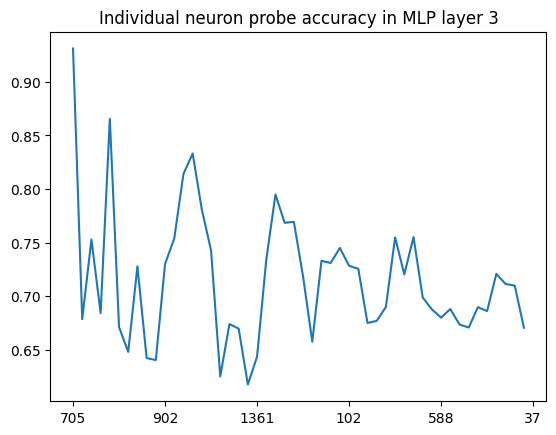

In [53]:
g = sns.lineplot(train_accs.mean(0))
g.set_xticklabels(topk)
g.set_title("Individual neuron probe accuracy in MLP layer 3")

In [54]:
top_k_indices, top_k_scores

(tensor([ 609,  705, 1361,  588,  902,  102,   37, 1715, 1847, 1932]),
 tensor([2.3957, 0.7343, 0.6351, 0.6067, 0.6059, 0.5978, 0.5614, 0.4795, 0.4678,
         0.4551]))

## Test ablation performance

In [55]:
french_activation_L3N609 = french_acts[:, 609]
non_french_activation_L3N609 = non_french_acts[:, 609]
mean_french_activation_L3N609 = french_acts[:, 609].mean(0)
mean_non_french_activation_L3N609 = non_french_acts[:, 609].mean(0)
print("French activation:", mean_french_activation_L3N609.mean(0).item())
print("Non french activation:", mean_non_french_activation_L3N609.mean(0).item())

French activation: 2.3420767784118652
Non french activation: -0.06485679000616074


<Axes: ylabel='Count'>

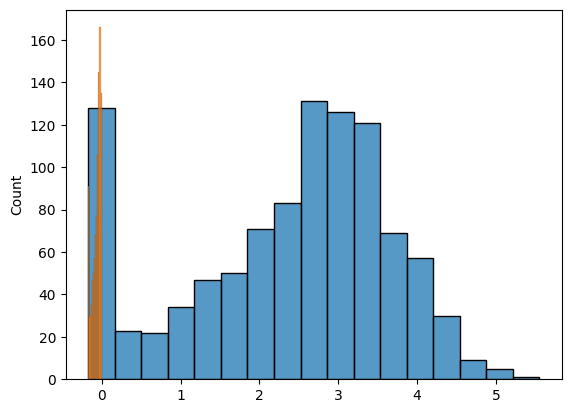

In [56]:
sns.histplot(french_activation_L3N609.cpu().numpy())
sns.histplot(non_french_activation_L3N609.cpu().numpy())

In [57]:
act_label_l3 = f'blocks.3.mlp.hook_post'

In [58]:
def ablate_neuron_hook(value, hook):
  # Shape [batch pos d_mlp]
  #if hook.layer() == 3:
  value[:, :, 609] = mean_non_french_activation_L3N609
  return value

tokens = model.to_tokens(french[500:532])
print(tokens.shape)
original_loss = model(tokens, return_type="loss")
ablated_loss = model.run_with_hooks(tokens, return_type="loss", fwd_hooks=[(act_label_l3, ablate_neuron_hook)])

print(f"Full model loss: {original_loss:.6f}")
print(f"Ablated MLP layer loss: {ablated_loss:.6f}")

torch.Size([32, 521])
Full model loss: 6.603084
Ablated MLP layer loss: 6.703305


In [59]:
# Summary Statistics for KDE dataset on Pythia
# average loss around 3
# loss increase from ablating french neuron around 6%

average_original_loss = 0
average_ablated_loss = 0

min_original_loss = math.inf
paired_ablated_loss = math.inf

for sample in french:
  tokens = model.to_tokens(sample)
  original_loss = model(tokens, return_type="loss")
  ablated_loss = model.run_with_hooks(tokens, return_type="loss", fwd_hooks=[(act_label_l3, ablate_neuron_hook)])

  if (original_loss < min_original_loss):
    min_original_loss = original_loss
    paired_ablated_loss = ablated_loss
    min_original_loss = original_loss

  average_original_loss += original_loss
  average_ablated_loss += ablated_loss

average_original_loss /= len(french)
average_ablated_loss /= len(french)

print(f"Full model loss: {average_original_loss:.6f}")
print(f"Ablated MLP layer loss: {average_ablated_loss:.6f}")
print(f"% increase: {((average_ablated_loss - average_original_loss) / average_original_loss).item() * 100:.6f}")

print(f'{min_original_loss=}')
print(f'{paired_ablated_loss=}')

Full model loss: 3.583874
Ablated MLP layer loss: 3.808673
% increase: 6.272504
min_original_loss=tensor(0.8048, device='cuda:0')
paired_ablated_loss=tensor(0.8037, device='cuda:0')


## Loss from disabling/enabling the neuron on non-French text

In [60]:
def enable_neuron_hook(value, hook):
  # value shape is [batch pos d_mlp]
  value[:, :, 609] = mean_french_activation_L3N609
  return value


def compare_loss_with_ablated(data, ablate_hook):
  average_original_loss = 0
  average_ablated_loss = 0

  for sample in data:
    tokens = model.to_tokens(sample)
    average_original_loss += model(tokens, return_type="loss")
    average_ablated_loss +=  model.run_with_hooks(tokens, return_type="loss", fwd_hooks=[(act_label_l3, ablate_hook)])

  average_original_loss /= len(data)
  average_ablated_loss /= len(data)

  print(f"Full model loss: {average_original_loss:.6f}")
  print(f"Ablated MLP layer loss: {average_ablated_loss:.6f}")
  print(f"% increase: {((average_ablated_loss - average_original_loss) / average_original_loss).item() * 100:.6f}")


# Loss from disabling French neuron on non-French text - if this is high it disproves that the neuron is only relevant to non-French text (although it could be 
# due to French loanwords)
# It's very low
compare_loss_with_ablated(non_french, ablate_neuron_hook)
# Loss from enabling French neuron on non-French text - if this is high it shows that the neuron is influential on its own, not just as part of a circuit
# which we can discover. E.g., there's an unembedding direction which "translates" words and this neuron triggers it.
compare_loss_with_ablated(non_french, enable_neuron_hook)

Full model loss: 3.876772
Ablated MLP layer loss: 3.876870
% increase: 0.002521
Full model loss: 3.876772
Ablated MLP layer loss: 3.955415
% increase: 2.028571


## Modify pythia-70M-v1 language neurons in a failed attempt to get the model to predict German text

In [61]:
from collections import defaultdict
from haystack_utils import load_txt_data, get_mlp_activations

model = HookedTransformer.from_pretrained("EleutherAI/pythia-70m", fold_ln=True, device=device)

# Interesting neurons in Pythia V1, taken from Wes' CSV
english_neurons = [(5, 395), (5, 166), (5, 908), (5, 285), (3, 862), (5, 73), (4, 896), (5, 348), (5, 297), (3, 1204)]
german_neurons = [(4, 482), (5, 1039), (5, 407), (5, 1516), (5, 1336), (4, 326), (5, 250), (3, 669)]
french_neurons = [(5, 112), (4, 1080), (5, 1293), (5, 455), (5, 5), (5, 1901), (5, 486), (4, 975)]
# German neurons that still score highly on our dataset
german_neurons_our_score = [(3, 669), (5, 1336), (4, 482), (5, 1039), (4, 326)]

# Get German data and mean neuron activations
german_data = load_txt_data("german_stories.txt")
english_data = load_txt_data("kde4_english.txt")
french_data = load_txt_data("kde4_french.txt")

german_mean_high_activations = defaultdict(torch.Tensor, {
    3: get_mlp_activations(german_data, 3, model, mean=True),  # [2048]
    4: get_mlp_activations(german_data, 4, model, mean=True),
    5: get_mlp_activations(german_data, 5, model, mean=True)
})
german_mean_low_activations = defaultdict(torch.Tensor, {
    3: get_mlp_activations(english_data, 3, model, mean=True),  # [2048]
    4: get_mlp_activations(english_data, 4, model, mean=True),
    5: get_mlp_activations(english_data, 5, model, mean=True)
})
english_mean_high_activations = defaultdict(torch.Tensor, {
    3: get_mlp_activations(english_data, 3, model, mean=True),  # [2048]
    4: get_mlp_activations(english_data, 4, model, mean=True),
    5: get_mlp_activations(english_data, 5, model, mean=True)
})
english_mean_low_activations = defaultdict(torch.Tensor, {
    3: get_mlp_activations(german_data, 3, model, mean=True),  # [2048]
    4: get_mlp_activations(german_data, 4, model, mean=True),
    5: get_mlp_activations(german_data, 5, model, mean=True)
})
french_mean_high_activations = defaultdict(torch.Tensor, {
    4: get_mlp_activations(french_data, 4, model, mean=True),
    5: get_mlp_activations(french_data, 5, model, mean=True)
})
french_mean_low_activations = defaultdict(torch.Tensor, {
    4: get_mlp_activations(english_data, 4, model, mean=True),
    5: get_mlp_activations(english_data, 5, model, mean=True)
})

english_neurons_by_layer = defaultdict(list)
for item in english_neurons:
    english_neurons_by_layer[item[0]].append(item[1])
german_neurons_by_layer = defaultdict(list)
for item in german_neurons:
    german_neurons_by_layer[item[0]].append(item[1])
french_neurons_by_layer = defaultdict(list)
for item in french_neurons:
    french_neurons_by_layer[item[0]].append(item[1])

Using pad_token, but it is not set yet.


Loaded pretrained model EleutherAI/pythia-70m into HookedTransformer
german_stories.txt: Loaded 20 examples with 243 to 312 characters each.
kde4_english.txt: Loaded 1007 examples with 501 to 5295 characters each.
kde4_french.txt: Loaded 1007 examples with 505 to 5345 characters each.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1007 [00:00<?, ?it/s]

  0%|          | 0/1007 [00:00<?, ?it/s]

  0%|          | 0/1007 [00:00<?, ?it/s]

  0%|          | 0/1007 [00:00<?, ?it/s]

  0%|          | 0/1007 [00:00<?, ?it/s]

  0%|          | 0/1007 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1007 [00:00<?, ?it/s]

  0%|          | 0/1007 [00:00<?, ?it/s]

  0%|          | 0/1007 [00:00<?, ?it/s]

  0%|          | 0/1007 [00:00<?, ?it/s]

In [81]:
def get_activate_german_multiple_hook(multiple: int):
    def activate_german_hook(value, hook):
        layer = hook.layer()
        german_neurons_for_layer = german_neurons_by_layer[layer]
        english_neurons_for_layer = english_neurons_by_layer[layer]

        value[:, :, german_neurons_for_layer] = german_mean_high_activations[layer][german_neurons_for_layer].cuda() * multiple
        value[:, :, english_neurons_for_layer] = english_mean_low_activations[layer][english_neurons_for_layer].cuda()
        return value
    return activate_german_hook


# our_german_neurons_by_layer = defaultdict(list)
# for item in german_neurons:
#     our_german_neurons_by_layer[item[0]].append(item[1])
# def activate_german_hook_our_neurons(value, hook):
#     layer = hook.layer()
#     german_neurons_for_layer = our_german_neurons_by_layer[layer]
#     english_neurons_for_layer = english_neurons_by_layer[layer]

#     value[:, :, german_neurons_for_layer] = german_mean_high_activations[layer][german_neurons_for_layer].cuda() * 3
#     value[:, :, english_neurons_for_layer] = english_mean_low_activations[layer][english_neurons_for_layer].cuda()
#     return value


def activate_german_hook(value, hook):
    layer = hook.layer()
    german_neurons_for_layer = german_neurons_by_layer[layer]
    english_neurons_for_layer = english_neurons_by_layer[layer]

    value[:, :, german_neurons_for_layer] = german_mean_high_activations[layer][german_neurons_for_layer].cuda() * 2.2
    value[:, :, english_neurons_for_layer] = english_mean_low_activations[layer][english_neurons_for_layer].cuda()
    return value

def activate_english_hook(value, hook):
    layer = hook.layer()
    german_neurons_for_layer = german_neurons_by_layer[layer]
    english_neurons_for_layer = english_neurons_by_layer[layer]

    value[:, :, german_neurons_for_layer] = german_mean_low_activations[layer][german_neurons_for_layer].cuda()
    value[:, :, english_neurons_for_layer] = english_mean_high_activations[layer][english_neurons_for_layer].cuda()
    return value

# Uses words present in both German and English
german_english_prompt = "Gift. Definition:"
german_english_prompt_2 = "Bank"
english_prompt = "Though this detail has absolutely no bearing"

name_filter = lambda name: name.endswith("mlp.hook_post")
print(haystack_utils.generate_text(english_prompt, model, fwd_hooks=[(name_filter, activate_german_hook)], k=50))
# print(haystack_utils.generate_text(english_prompt, model, fwd_hooks=[(name_filter, activate_german_hook_our_neurons)], k=50))


Though this detail has absolutely no bearing on the die-off, der die-off, der die-off, der die-off, der die-off, der die-off, der die-off, der die-off, der die-off, der die-off
Though this detail has absolutely no bearingde der Ande der Ande der Ande der Ande der Ande der Ande der Ande der Ande der Ande der Ande der Ande der Ande der Ande der Ande der Ande der Ande der


## Clean French to English hook

In [63]:
def activate_english_hook(value, hook):
    layer = hook.layer()
    # german_neurons_for_layer = german_neurons_by_layer[layer]
    english_neurons_for_layer = english_neurons_by_layer[layer]

    # value[:, :, german_neurons_for_layer] = german_mean_low_activations[layer][german_neurons_for_layer].cuda()
    value[:, :, english_neurons_for_layer] = english_mean_high_activations[layer][english_neurons_for_layer].cuda()

    if layer == 3:
        value[:, :, 609] = mean_french_activation_L3N609
    return value

french_prompt = "Je suis un chat. Bonjour"
tokens = model.to_tokens(french_prompt).cuda()
tokens = tokens[:, :-1] # remove the jour token

print("Baseline prediction on French prompt:")
print(haystack_utils.generate_text(french_prompt, model, truncate_index=-1))
print("\nWith English neurons activated:")
print(haystack_utils.generate_text(french_prompt, model, fwd_hooks=[(lambda name: name.endswith("mlp.hook_post"), activate_english_hook)], truncate_index=-1))


french_prompt = "Quoique ce détail ne touche en aucune manière au fond même de ce que nous avons à raconter"
# tokens = model.to_tokens(french_prompt).cuda()

print("\nBaseline prediction on French prompt:")
print(haystack_utils.generate_text(french_prompt, model))
print("\nWith English neurons activated:")
print(haystack_utils.generate_text(french_prompt, model, fwd_hooks=[(lambda name: name.endswith("mlp.hook_post"), activate_english_hook)]))

Baseline prediction on French prompt:
Je suis un chat. Bonjour, je suis un chatte, je suis un chatte, je suis un chatte,

With English neurons activated:


Je suis un chat. Bonus: I’m not going to be a chatty chatty chatty chatty chatty

Baseline prediction on French prompt:
Quoique ce détail ne touche en aucune manière au fond même de ce que nous avons à raconter les trois ans de la première fois.

Le détail de la première fois,

With English neurons activated:
Quoique ce détail ne touche en aucune manière au fond même de ce que nous avons à raconter les questions about the nature of the human race.

On a question about the nature of the


## High Loss Difference German Prompts

In [64]:
# Create a maximally sized German dataset

from datasets import load_dataset

wmt_german = load_dataset('wmt16', 'de-en', split='train')

# german_data = load_txt_data("german_stories.txt")
wmt_german_large = []
for item in wmt_german:
    # print(item)
    german_item = item['translation']['de']
    if len(german_item) < 800:
        continue
    else:
        wmt_german_large.append(german_item[:2000])

print(wmt_german_large[:5])

with (open("wmt_german_large.txt", "w")) as f:
    for item in wmt_german_large:
        f.write(item + '\n')


Found cached dataset wmt16 (/root/.cache/huggingface/datasets/wmt16/de-en/1.0.0/746749a11d25c02058042da7502d973ff410e73457f3d305fc1177dc0e8c4227)


['Aus diesem Grund ist es eines der wichtigsten und weitreichendsten Ziele, die wir uns in der Europäischen Union stellen sollten, Anstrengungen zur Schaffung neuer Arbeitsplätze in den ländlichen Gebieten außerhalb des Agrarsektors zu unternehmen, unter anderem in den Bereichen ländlicher Tourismus, Sport, Kultur, Sanierung der Ressourcen, Umstellung von Unternehmen, neue Technologien, Dienstleistungen usw. Doch obwohl die Landwirtschaft keine ausschließliche Rolle mehr spielt, ist sie weiterhin wichtig, nicht nur, um den wirtschaftlichen und sozialen Niedergang der ländlichen Gebiete und das Entstehen von weiteren Geisterstädten zu verhindern, sondern auch, weil den Landwirten eine grundlegende Rolle bei der Bewirtschaftung des Territoriums, dem Erhalt der Artenvielfalt und dem Umweltschutz zukommt.', 'Angesichts dieser Situation muß aus dem Bericht, den das Parlament annimmt, klar hervorgehen, daß Maßnahmen notwendig sind, die eindeutig auf die Bekämpfung der relativen Armut und der

In [ ]:
with open("wmt_german_large.txt", "r") as f:
  wmt_german = f.readlines()

def deactivate_german_hook(value, hook):
    layer = hook.layer()
    german_neurons_for_layer = german_neurons_by_layer[layer]
    value[:, :, german_neurons_for_layer] = german_mean_low_activations[layer][german_neurons_for_layer].cuda()
    return value

def get_high_loss_difference_prompts(data, fwd_hooks=[], k=10):
  top_k_indices = torch.zeros((k, 2), dtype=int)
  top_k_loss_diffs = torch.zeros(k)

  for i, sample in enumerate(data):
    tokens = model.to_tokens(sample)
    original_loss = model(tokens, return_type="loss", loss_per_token=True)
    ablated_loss =  model.run_with_hooks(tokens, return_type="loss", loss_per_token=True, fwd_hooks=fwd_hooks)
    difference = ablated_loss - original_loss

    top_k_index_min = torch.argmin(top_k_loss_diffs)
    current_index_max = torch.argmax(difference)
    # print(top_k_index_min, current_index_max)

    while top_k_loss_diffs[top_k_index_min] < difference[0, current_index_max]:
      top_k_loss_diffs[top_k_index_min] = difference[0, current_index_max]
      # print(top_k_indices[top_k_index_min, :])
      top_k_indices[top_k_index_min, 0] = i
      top_k_indices[top_k_index_min, 1] = current_index_max

      difference[0, current_index_max] = 0
      top_k_index_min = torch.argmin(top_k_loss_diffs)
      current_index_max = torch.argmax(difference)
  
  # tuple of [prompt index, token index] and list of loss differences
  return top_k_indices, top_k_loss_diffs

mlp_pattern = lambda name: name.endswith("mlp.hook_post")
top_k_indices, top_k_loss_diffs = get_high_loss_difference_prompts(wmt_german, [(mlp_pattern, deactivate_german_hook)])

In [ ]:
print(top_k_loss_diffs)
print(top_k_indices)

with (open("high_loss_diff_german_tokens.txt", "w")) as f:
    for prompt_index, token_index in top_k_indices.tolist():
        prompt = wmt_german[prompt_index]
        tokens = model.to_tokens(prompt)
        token = model.to_single_str_token(tokens[0, token_index].item())
        next_token = model.to_single_str_token(tokens[0, token_index + 1].item())

        f.write(str({"token": token, "next_token": next_token, "token_index": token_index, "prompt": prompt, "prompt_index": prompt_index}) + '\n')

tensor([8.0178, 8.8304, 8.6936, 8.8011, 9.8167, 7.8172, 9.8167, 9.8170, 9.5294,
        8.5362])
tensor([[1123,   26],
        [1112,   31],
        [  13,   38],
        [1404,   97],
        [ 716,    3],
        [ 251,  107],
        [ 478,    3],
        [ 516,    3],
        [ 919,   82],
        [1094,  102]])


## Get ~100 high loss tokens and cluster by problematic bigram

In [83]:
mlp_pattern = lambda name: name.endswith("mlp.hook_post")
top_k_indices, top_k_loss_diffs = get_high_loss_difference_prompts(wmt_german, [(mlp_pattern, deactivate_german_hook)], k=100)

# with (open("clustered_high_loss_bigrams.txt", "w")) as f:
bigrams_dict = defaultdict(list)
for prompt_index, token_index in top_k_indices.tolist():
    prompt = wmt_german[prompt_index]
    tokens = model.to_tokens(prompt)
    token = model.to_single_str_token(tokens[0, token_index].item())
    next_token = model.to_single_str_token(tokens[0, token_index + 1].item())

    bigrams_dict[(token, next_token)].append({"token_index": token_index, "prompt_index": prompt_index, "prompt": prompt})
    # f.write(str({"token": token, "next_token": next_token, "token_index": token_index, "prompt": prompt, "prompt_index": prompt_index}) + '\n')

(('ät', 'ig'), [{'token_index': 136, 'prompt_index': 723, 'prompt': 'Ich stimme für diesen Vorschlag angesichts der Tatsache, dass die Krise Millionen von Arbeitsplätzen zunichte gemacht sowie Beschäftigungsunsicherheit und Armut verschärft hat; dass 17 % der EU-Bevölkerung von Armut bedroht sind; dass 23 Millionen Einwohner der EU arbeitslos sind; dass ein großer Teil der Hausarbeit in der Schattenwirtschaft in unsicheren Beschäftigungsverhältnissen und/oder als nicht angemeldete Erwerbstätigkeit geleistet wird und dass zudem in den Industrieländern zwischen 5 und 9 % aller Arbeitsplätze auf die Hausarbeit entfallen; dass die meisten Erwerbstätigen in diesem Bereich Frauen sind; dass diese Arbeit unterbewertet wird, unterbezahlt ist und dass es sich dabei um Schwarzarbeit handelt; und dass die Schutzlosigkeit der Hausangestellten bedeutet, dass sie oft diskriminiert werden sowie leicht ungleich und unfair behandelt und missbraucht werden können.\n'}, {'token_index': 177, 'prompt_index

In [89]:
temp = dict(sorted(bigrams_dict.items(), key=lambda item: -len(item[1])))
for key, value in temp.items():
    print(len(value), key)

20 ('id', 'ig')
7 ('rt', 'ige')
5 (' Vert', 'rag')
5 ('he', 'ben')
4 ('ät', 'ig')
4 ('nd', 'liche')
3 ('in', 'we')
3 (' Sie', ' mich')
3 ('mt', 'lic')
3 ('us', 'chen')
2 ('lt', 'ig')
2 ('bes', 'onde')
2 ('d', 'ruck')
2 ('st', 'abe')
2 (' B', 'ür')
2 ('hr', 'te')
2 ('z', 'uden')
2 ('z', 'te')
2 ('ng', 'lichen')
1 ('ass', 'enden')
1 ('ge', 'hung')
1 (' Lau', 'fb')
1 (' Ans', 'icht')
1 ('ät', 'igen')
1 ('id', 'iger')
1 ('ug', 'nis')
1 ('ent', 'lichen')
1 (' bef', 'assen')
1 (' christ', 'lichen')
1 ('in', 'w')
1 ('its', 'bed')
1 ('ug', 'n')
1 ('hn', 'ten')
1 ('nd', 'lichen')
1 ('ries', 'igen')
1 ('acht', 'et')
1 ('ts', 'ver')
1 ('sp', 'rin')
1 ('ch', 'ät')
1 (' he', 'ute')
1 ('for', 'dern')
1 ('re', 'ib')
1 (' Um', 'verte')
1 ('feren', ' Ver')
